# Cleaning

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import os
import json
import seaborn as sns
import tensorflow as tf
import random
import cv2
from PIL import Image


from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,classification_report
from sklearn.preprocessing import normalize,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.compose import ColumnTransformer
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import LabelBinarizer



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D,LeakyReLU
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from scipy.stats import skew
from scipy.sparse import csr_matrix

### YoloV4 (Tiny)

In [ ]:
image_dir = "Datasets/VMMRdb/"

In [ ]:
net = cv2.dnn.readNet("models/yolov4-tiny.weights", "models/yolov4-tiny.cfg")

# Load classes
classes = []
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

In [ ]:
classes[:5]

In [ ]:
input_size = (416, 416)
scale = 1/255.0

### Bounding Box Identification

In [ ]:
output_dir = "Datasets/BoundingBoxes/"

for root, dirs, files in os.walk('Datasets/VMMRdb/'):
    for filename in files:
        # Check if output file already exists
        output_path = os.path.join('Datasets/BoundingBoxes', os.path.basename(root), filename)
        if os.path.exists(output_path):
            continue  # skip file if it already exists

        # Load image
        img = cv2.imread(os.path.join(root, filename))
        if img is None:
            continue  # skip file if unable to load

        orig_h, orig_w = img.shape[:2]
        blob = cv2.dnn.blobFromImage(img, scale, input_size, swapRB=True, crop=False)

        # Set input and output layers
        net.setInput(blob)
        output_layers = net.getUnconnectedOutLayersNames()

        # Forward pass through network
        layer_outputs = net.forward(output_layers)

        # Process detections
        boxes = []
        confidences = []
        class_ids = []
        for output in layer_outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    center_x = int(detection[0] * orig_w)
                    center_y = int(detection[1] * orig_h)
                    width = int(detection[2] * orig_w)
                    height = int(detection[3] * orig_h)
                    x = int(center_x - width/2)
                    y = int(center_y - height/2)
                    boxes.append([x, y, width, height])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        # Apply non-max suppression
        indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.95)

        # Save cropped images
        if len(indices) > 0:
            for i in indices.flatten():
                box = boxes[i]
                x, y, w, h = box
                label = classes[class_ids[i]]
                im = Image.open(os.path.join(root, filename))
                cropped_im = im.crop((x, y, x+w, y+h))

                output_path = os.path.join(output_dir, os.path.basename(root), f"{label}_{filename}")
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                cropped_im.save(output_path)

### File Reduction

The bounding box generation created many files that were captured as part of another image. For instance, the bounding boxes were created for the object (vehicle) in the foreground, as well as the behicles in the background. We want to remove the images that were generated for the vehicles in the background.

In [4]:
folder_path = "Datasets/BoundingBoxes/"

for root, dirs, files in os.walk(folder_path):
    for filename in files:
        file_path = os.path.join(root, filename)
        if os.path.getsize(file_path) < 10240:  # 10kb in bytes
            os.remove(file_path)

### Vehicle Model Counts

In [ ]:
folder_path = "Datasets/BoundingBoxes/"

In [30]:
brands = {}

# Loop through each subfolder in the main folder
for root, dirs, files in os.walk(folder_path):
    # Loop through each file in the subfolder
    for file in files:
        # Check if it's an image file
        if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
            # Split the subfolder name into brand and model
            brand = os.path.basename(root).split("_")[0]
            # Add the brand to the dictionary
            if brand in brands:
                brands[brand] += 1
            else:
                brands[brand] = 1
                

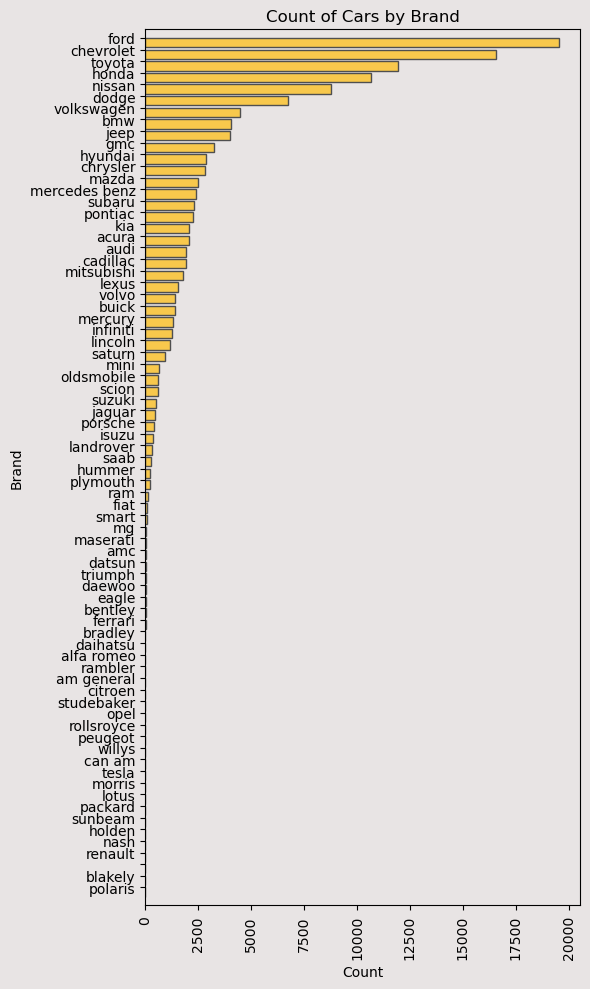

In [31]:
sorted_categories = sorted(categories.items(), key=lambda x: x[1], reverse=True)

yellow = '#f8c84c'
grey = '#4F4F4F'
background = '#e8e4e4'

# Create the color map
colors = [grey, yellow]
cmap = LinearSegmentedColormap.from_list('my_palette', colors)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(6, 10), facecolor=background)
ax.barh([x[0] for x in sorted_categories], [x[1] for x in sorted_categories],color=colors[1], edgecolor=grey, linewidth=1, align='edge')
ax.invert_yaxis() # invert the y-axis to show larger values on top

# Set the axis labels and title
ax.set_xlabel('Count')
ax.set_facecolor(background)
ax.set_ylabel('Brand')
ax.set_title('Count of Cars by Brand')

plt.xticks(rotation=90)
plt.tight_layout()
plt.margins(y=.01, tight=True)

plt.show()

### Count of Image Types

In [7]:
categories = {}

# Loop through each subfolder in the folder
for dirpath, dirnames, filenames in os.walk("Datasets/BoundingBoxes/"):
    # Ignore .DS_Store files
    filenames = [f for f in filenames if not f.startswith('.')]
    
    # Loop through each file in the subfolder
    for filename in filenames:
        # Split the filename into category and file name
        category, file_name = filename.split("_", 1)

        # Check if the category exists in the dictionary
        if category in categories:
            categories[category] += 1
        else:
            categories[category] = 1

# Print the count for each category
for category, count in categories.items():
    print(category, count)

car 81904
truck 44744
aeroplane 92
bus 1434
motorbike 302
train 194
suitcase 82
parking meter 166
oven 114
cup 3
cell phone 46
traffic light 1
laptop 3
toilet 17
boat 6
bench 2
bicycle 1
person 5
vase 3
tvmonitor 5
keyboard 3
bottle 2
pizza 1
sink 2
cake 1
clock 2
bed 1


Generally YoloV4 did a good job of classifying the images as car,truck, etc. However there do seem to be <1000 images that are of a unique class that would be unnecessary to include in our model. Upon further inspection of the images themselves, the majority of these images are actually a misclassication by the Yolo model and are still relevant to the problem at hand.

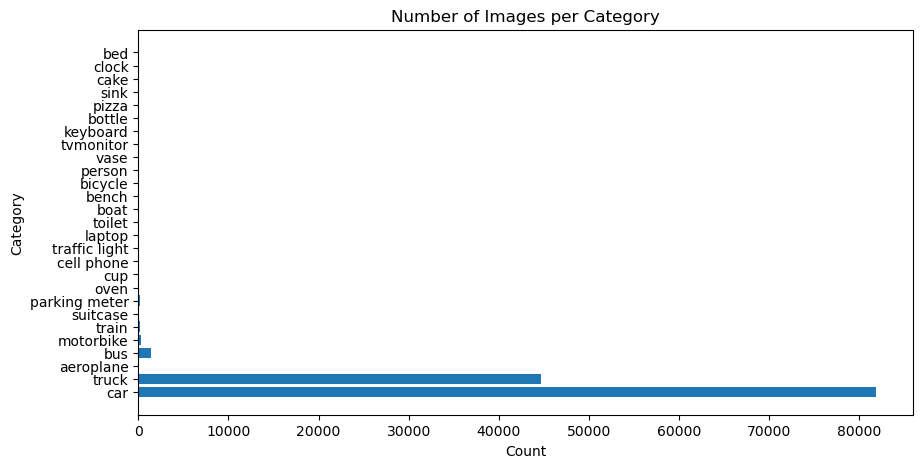

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(list(categories.keys()), list(categories.values()))

# Set the title and axis labels
ax.set_title('Number of Images per Category')
ax.set_xlabel('Count')
ax.set_ylabel('Category')

# Display the chart
plt.show()

In [9]:
folder_path = "Datasets/BoundingBoxes/"

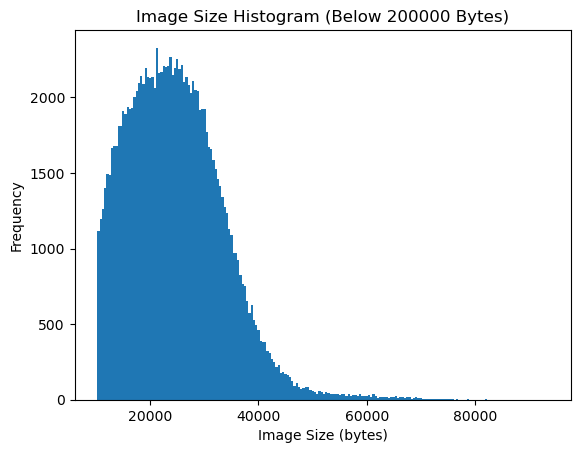

In [19]:
sizes = []

for dirpath, dirnames, filenames in os.walk("Datasets/BoundingBoxes/"):
    # Loop through each file in the subfolder
    for filename in filenames:
        # Check if it's an image file
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            # Get the size of the image
            filepath = os.path.join(dirpath, filename)
            size = os.path.getsize(filepath)
            if size < 100000:
                sizes.append(size)

# Plot the histogram
plt.hist(sizes, bins=200)
plt.title("Image Size Histogram (Below 200000 Bytes)")
plt.xlabel("Image Size (bytes)")
plt.ylabel("Frequency")
plt.show()


The above histogram shows the distribution of file sizes in our dataset. I needed to calculate this to ensure there weren't a significant number of outliers in the data. If there were only a handfull of values slightly greater than 10kb, I would've had to adjust the cutoff. Similar to any values on the higher end.

### Image Conversion

In [ ]:
image_dir = "Datasets/VMMRdb/"

In [ ]:
def convert_images_to_jpg(image_dir):
    for folder_name in os.listdir(image_dir):
        folder_path = os.path.join(image_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if image_path.endswith('.jpg') or image_path.endswith('.jpeg'):
                continue
            try:
                with Image.open(image_path) as im:
                    im = im.convert('RGB')
                    new_image_path = os.path.splitext(image_path)[0] + '.jpg'
                    im.save(new_image_path, quality=95)
                os.remove(image_path)
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")

In [ ]:
convert_images_to_jpg(image_dir)

In [327]:
def lonelyinteger(a):
    results =[]
    nums = [results.append(num) for num in a if num not in results]
    for 
    return results

In [328]:
a= [1,2,3,4,3,2,1]

In [329]:
lonelyinteger(a)

[1, 2, 3, 4]